In [ ]:
# Instalação de dependências necessárias
#!pip install kagglehub scikit-image scikit-learn opencv-python matplotlib --quiet

# Importação do kagglehub e download do dataset
import kagglehub

# Baixar a versão mais recente do dataset de pneumonia
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.29G/2.29G [00:30<00:00, 80.1MB/s]

Extracting files...


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2


In [2]:
import os
import glob
import random
import shutil
from sklearn.model_selection import train_test_split

# Caminhos das pastas do dataset
base_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")

# Função para coletar imagens positivas (PNEUMONIA) e negativas (NORMAL)
def coletar_imagens(pasta, categoria, max_imgs=None):
    imgs = glob.glob(os.path.join(pasta, categoria, "*.jpeg"))
    if max_imgs:
        imgs = random.sample(imgs, min(max_imgs, len(imgs)))
    return imgs

# Coletar até 100 exemplos positivos e negativos de treino e teste
positivos = coletar_imagens(train_dir, "PNEUMONIA", 100)
negativos = coletar_imagens(train_dir, "NORMAL", 100)

# Balancear e criar lista de imagens e rótulos
data = positivos + negativos
labels = [1]*len(positivos) + [0]*len(negativos)

# Separar em treino e teste (70-30), mantendo balanceamento
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)

print(f"Treino: {len(X_train)} imagens, Teste: {len(X_test)} imagens")

Treino: 140 imagens, Teste: 60 imagens


In [3]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import numpy as np

# Parâmetros para HOG
IMG_SIZE = (128, 128)  # Tamanho padrão das imagens
HOG_PARAMS = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'feature_vector': True
}

def extrair_hog(im_path):
    img = imread(im_path, as_gray=True)
    img = resize(img, IMG_SIZE)
    features = hog(img, **HOG_PARAMS)
    return features

# Extrair HOG para todas as imagens de treino e teste
X_train_hog = np.array([extrair_hog(p) for p in X_train])
X_test_hog = np.array([extrair_hog(p) for p in X_test])

print(f"Vetor HOG de treino: {X_train_hog.shape}, teste: {X_test_hog.shape}")

Vetor HOG de treino: (140, 8100), teste: (60, 8100)


In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Treinar SVM com os vetores HOG
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train_hog, y_train)

# Classificar imagens de treino e teste
y_train_pred = svm.predict(X_train_hog)
y_test_pred = svm.predict(X_test_hog)

# Avaliar acurácia
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"Acurácia treino: {acc_train:.2f}, teste: {acc_test:.2f}")
print("Relatório de classificação (teste):\n", classification_report(y_test, y_test_pred))

Acurácia treino: 1.00, teste: 0.90
Relatório de classificação (teste):
               precision    recall  f1-score   support

           0       0.85      0.97      0.91        30
           1       0.96      0.83      0.89        30

    accuracy                           0.90        60
   macro avg       0.91      0.90      0.90        60
weighted avg       0.91      0.90      0.90        60



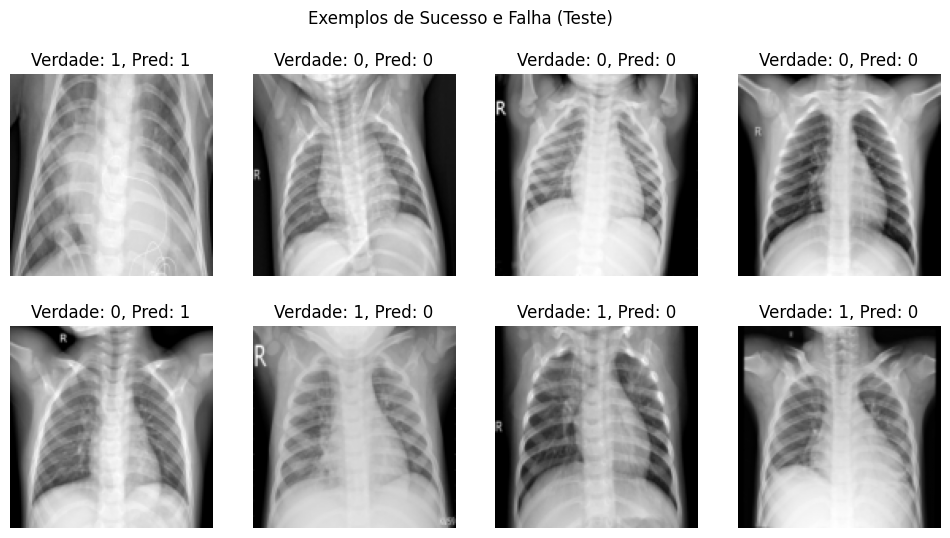

In [5]:
import matplotlib.pyplot as plt

# Função para mostrar exemplos de sucesso e falha

def mostrar_exemplos(X, y_true, y_pred, n=4, titulo=""):    
    acertos = [i for i in range(len(y_true)) if y_true[i] == y_pred[i]]
    erros = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]
    exemplos = random.sample(acertos, min(n, len(acertos))) + random.sample(erros, min(n, len(erros)))
    plt.figure(figsize=(12, 6))
    for idx, i in enumerate(exemplos):
        img = imread(X[i], as_gray=True)
        img = resize(img, IMG_SIZE)
        plt.subplot(2, n, idx+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Verdade: {y_true[i]}, Pred: {y_pred[i]}")
    plt.suptitle(titulo)
    plt.show()

# Exemplos do teste
mostrar_exemplos(X_test, y_test, y_test_pred, n=4, titulo="Exemplos de Sucesso e Falha (Teste)")

In [11]:
# Criando PDF com todos os resultados do projeto
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('resultados_classificacao_completo.pdf') as pdf:
    # Página 1: Informações do dataset
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    plt.title('Task 3: Image classification with HOG+SVM')
    plt.text(0.5, 0.9, 'Lucas Cardoso - 179737', fontsize=14, ha='center', va='center')
    texto = f"Treino: {len(X_train)} imagens\nTeste: {len(X_test)} imagens\nPositivos (PNEUMONIA): {len([l for l in y_train if l==1])} treino, {len([l for l in y_test if l==1])} teste\nNegativos (NORMAL): {len([l for l in y_train if l==0])} treino, {len([l for l in y_test if l==0])} teste"
    plt.text(0.5, 0.5, texto, fontsize=14, ha='center', va='center')
    pdf.savefig()
    plt.close()

    # Página 2: Parâmetros HOG
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    plt.title('Parâmetros do HOG')
    texto = f"IMG_SIZE: {IMG_SIZE}\nOrientations: {HOG_PARAMS['orientations']}\nPixels per cell: {HOG_PARAMS['pixels_per_cell']}\nCells per block: {HOG_PARAMS['cells_per_block']}\nBlock norm: {HOG_PARAMS['block_norm']}"
    plt.text(0.5, 0.5, texto, fontsize=14, ha='center', va='center')
    pdf.savefig()
    plt.close()

    # Página 3: Exemplo de imagem original e HOG
    idx_exemplo = random.choice(range(len(X_train)))
    img_ex = imread(X_train[idx_exemplo], as_gray=True)
    img_ex = resize(img_ex, IMG_SIZE)
    features_ex, hog_image = hog(img_ex, visualize=True, **HOG_PARAMS)
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_ex, cmap='gray')
    plt.title('Imagem Original')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG')
    plt.axis('off')
    plt.suptitle('Exemplo de Extração HOG')
    pdf.savefig()
    plt.close()

    # Página 4: Matriz de Confusão (Treino)
    plt.figure(figsize=(8, 6))
    cm_train = confusion_matrix(y_train, y_train_pred)
    plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão (Treino)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Pneumonia'])
    plt.yticks(tick_marks, ['Normal', 'Pneumonia'])
    thresh = cm_train.max() / 2.
    for i, j in np.ndindex(cm_train.shape):
        plt.text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    pdf.savefig()
    plt.close()

    # Página 5: Matriz de Confusão (Teste)
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_test_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Matriz de Confusão (Teste)')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Pneumonia'])
    plt.yticks(tick_marks, ['Normal', 'Pneumonia'])
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Verdadeiro')
    plt.xlabel('Predito')
    pdf.savefig()
    plt.close()

    # Página 6: Relatório de Classificação (Treino)
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.title('Relatório de Classificação (Treino)')
    relatorio_train = classification_report(y_train, y_train_pred)
    plt.text(0.01, 0.5, relatorio_train, fontsize=12, ha='left', va='center', family='monospace')
    pdf.savefig()
    plt.close()

    # Página 7: Relatório de Classificação (Teste)
    plt.figure(figsize=(8, 6))
    plt.axis('off')
    plt.title('Relatório de Classificação (Teste)')
    relatorio = classification_report(y_test, y_test_pred)
    plt.text(0.01, 0.5, relatorio, fontsize=12, ha='left', va='center', family='monospace')
    pdf.savefig()
    plt.close()

    # Página 8: Exemplos de Sucesso e Falha (Treino)
    fig = plt.figure(figsize=(12, 6))
    acertos = [i for i in range(len(y_train)) if y_train[i] == y_train_pred[i]]
    erros = [i for i in range(len(y_train)) if y_train[i] != y_train_pred[i]]
    exemplos = random.sample(acertos, min(4, len(acertos))) + random.sample(erros, min(4, len(erros)))
    for idx, i in enumerate(exemplos):
        img = imread(X_train[i], as_gray=True)
        img = resize(img, IMG_SIZE)
        plt.subplot(2, 4, idx+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Verdade: {y_train[i]}, Pred: {y_train_pred[i]}")
    plt.suptitle("Exemplos de Sucesso e Falha (Treino)")
    pdf.savefig()
    plt.close()

    # Página 9: Exemplos de Sucesso e Falha (Teste)
    fig = plt.figure(figsize=(12, 6))
    acertos = [i for i in range(len(y_test)) if y_test[i] == y_test_pred[i]]
    erros = [i for i in range(len(y_test)) if y_test[i] != y_test_pred[i]]
    exemplos = random.sample(acertos, min(4, len(acertos))) + random.sample(erros, min(4, len(erros)))
    for idx, i in enumerate(exemplos):
        img = imread(X_test[i], as_gray=True)
        img = resize(img, IMG_SIZE)
        plt.subplot(2, 4, idx+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Verdade: {y_test[i]}, Pred: {y_test_pred[i]}")
    plt.suptitle("Exemplos de Sucesso e Falha (Teste)")
    pdf.savefig()
    plt.close()

print("Resultados completos salvos em 'resultados_classificacao_completo.pdf'")

Resultados completos salvos em 'resultados_classificacao_completo.pdf'
